In [15]:
%cd C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor

# imports
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.models.random_forest_regression import RandomForestRegression
import src.utils.standard_plots as sp
from scipy.stats import boxcox

C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor


In [40]:
data ={
    'train': 'data/intermediate/datasets/EASE2_LARM-smoothed_N3.125km_v1.1/ASP_train.parquet',
    'nov': 'data/intermediate/datasets/EASE2_LARM-smoothed_N3.125km_v1.1/ASP_test_2020-11-01_2020-12-01.parquet',
    'apr': 'data/intermediate/datasets/EASE2_LARM-smoothed_N3.125km_v1.1/ASP_test_2022-04-01_2022-05-01.parquet'
    }


train_df = pd.read_parquet(data['train'])
train_df = train_df[train_df['primary_id'].isin(['C2I'])]
nov_test_df = pd.read_parquet(data['nov'])
apr_test_df = pd.read_parquet(data['apr'])
test_df = pd.concat([nov_test_df, apr_test_df], ignore_index=True)

y_bc, lambda_ = boxcox(train_df['SD_mean'])

train_df['bc_SD_mean'] = y_bc
test_df['bc_SD_mean'] = boxcox(test_df['SD_mean'], lmbda=lambda_)

model = RandomForestRegression(
    input_features=['6.9H', '6.9V', '10.7H', '10.7V', '18H','18V', '23H', '23V', '36H', '36V', '89H', '89V','doy'],
    target_feature='bc_SD_mean',
    model_params={'n_estimators': 30, 'max_depth': 18,'max_features': 6,'min_samples_leaf': 1,'min_samples_split': 25
    },
    weight_feature='num_samples'
    )
model = model.fit(train_df)

In [41]:
def inv_boxcox(y_bc, lam):
    if lam == 0:
        return np.exp(y_bc)
    return np.power(lam * y_bc + 1, 1 / lam)

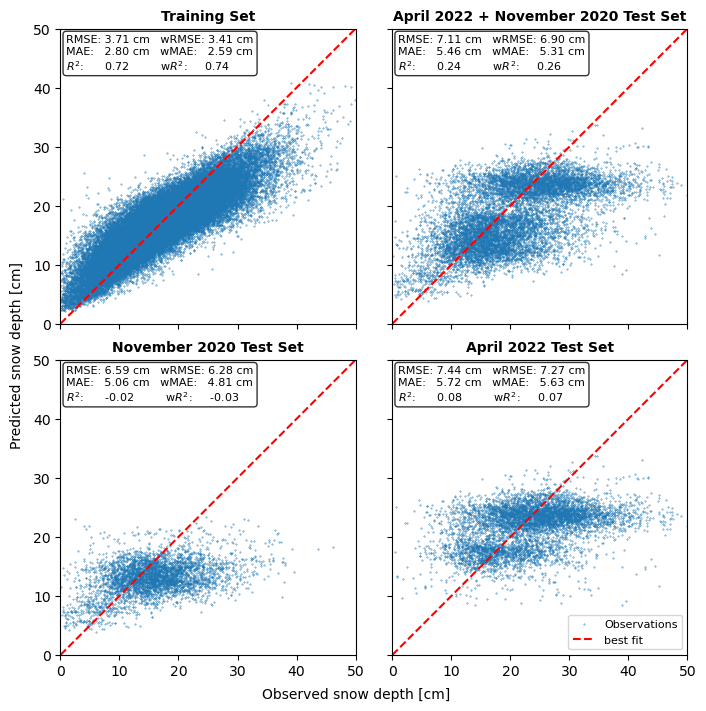

In [42]:


def obs_pred_plot(ax, y_true, y_pred, weights = None, val_range=(0,50),**kwargs):
    scatter = ax.scatter(y_true, y_pred, c=weights, label='Observations',**kwargs)
    ax.plot([val_range[0], val_range[1]], [val_range[0], val_range[1]], 'r--', label='best fit')
    ax.set_xlim(val_range)
    ax.set_ylim(val_range)



fig, ax = plt.subplots(2, 2, figsize=(7,7),sharex=True, sharey=True, layout='constrained')


ax = ax.flatten()
for df in [train_df, test_df, nov_test_df, apr_test_df]:
    df.dropna(inplace=True)
    y_true = df['SD_mean'].values
    y_pred = inv_boxcox(model.predict(df), lambda_)
    #weights = dataset['weight'].values

    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))*100
    wrmse = np.sqrt(np.mean(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples']))))*100
    mae = np.mean(np.abs(y_true - y_pred))*100
    wmae = np.mean(np.abs(y_true - y_pred) * (df['num_samples'] / np.mean(df['num_samples'])))*100
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    wr2 = 1 - (np.sum(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ) / np.sum( ((y_true - np.mean(y_true)) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ))


    if df.equals(train_df):
        title = 'Training Set'
        idx = 0
    elif df.equals(test_df):
        title = 'April 2022 + November 2020 Test Set'
        idx = 1
    elif df.equals(nov_test_df):
        title = 'November 2020 Test Set'
        idx = 2
    else:
        title = 'April 2022 Test Set'
        idx = 3

    obs_pred_plot(ax[idx], y_true*100, y_pred*100, val_range=(0,50), s=0.1)
    #ax[idx].set_title(f'{title}\nRMSE: {rmse:.4f}, MAE: {mae:.4f}')
    ax[idx].text(0.02, 0.98, 
        f"RMSE: {rmse:.2f} cm   wRMSE: {wrmse:.2f} cm" + "\n" +
        f"MAE:   {mae:.2f} cm   wMAE:   {wmae:.2f} cm" + "\n" +
        f"$R^2$:      {r2:.2f}         w$R^2$:     {wr2:.2f}", 
                transform=ax[idx].transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax[idx].set_title(f'{title}', fontsize=10, fontweight='bold')
    ax[idx].set_aspect('equal', 'box')
fig.supxlabel('Observed snow depth [cm]', fontsize=10)
fig.supylabel('Predicted snow depth [cm]', fontsize=10)
ax[-1].legend(loc=4,fontsize=8)
#fig.savefig('data/fig/scatter_TrainAndTestset.png', dpi=300)

In [37]:
%cd C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor

# -- built-in libraries --
import yaml

# -- third-party libraries  --
import pandas as pd
import numpy as np
#  -- custom modules  --
from src.models.random_forest_regression import RandomForestRegression

# Load configuration
with open("configs/pipeline_configs/create_RFR_model.yaml", 'r') as f:
    config = yaml.safe_load(f)

# Initialize model parameters
model_configs = config['model']['configs']
with open(config['model']['param_file'], 'r') as f:
    model_params = yaml.safe_load(f)
fixed_params = config['model']['fixed_params']
for p in fixed_params.keys():
    model_params[p] = fixed_params[p]

# Load training data
train_data_path = config['input_data']['train_data_paths']
if isinstance(train_data_path, str):
    train_data_path = [train_data_path]
train_data = pd.concat([pd.read_parquet(f) for f in train_data_path], ignore_index=True)
train_data = train_data[train_data['primary_id'].isin(config['input_data']['primary_ids']) & train_data['secondary_id'].isin(config['input_data']['secondary_ids'])]

# Initialize and create model
model = RandomForestRegression(model_params=model_params,**model_configs)
model.fit(train_data)
#model.save(config['output']['model_path'])

C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor
PixelPredictionModel with input features: ['6.9H', '6.9V', '10.7H', '10.7V', '18H', '18V', '23H', '23V', '36H', '36V', '89H', '89V', 'doy'] and target feature: SD_mean


In [43]:
model1 = pickle.load(open('data/processed/models/v1.2/ASP_RFR-model_LARM-smoothed_N3.125km.pkl','rb'))
model2 = pickle.load(open('data/processed/models/OIB/ASP_RFR-model_OIB_N3.125km.pkl','rb'))

In [44]:
p1 = model1.predict(train_df)
p2 = model2.predict(train_df)

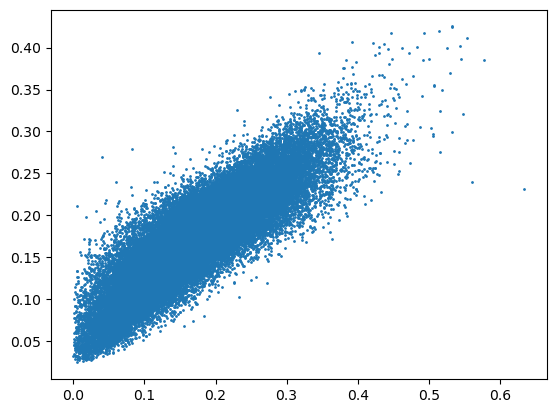

In [46]:
plt.scatter(train_df['SD_mean'], p1, s=1)

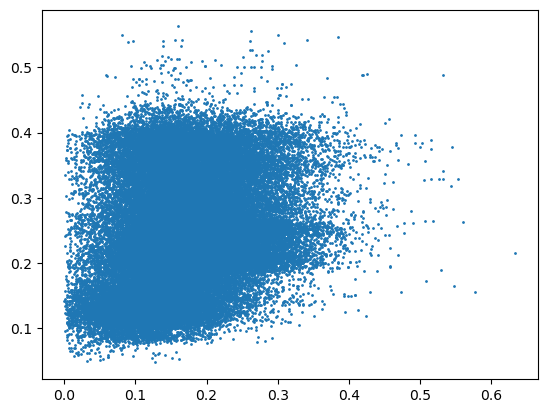

In [47]:

plt.scatter(train_df['SD_mean'], p2, s=1)